In [98]:
import os
import cv2.cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
sns.set()

In [99]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, \
    LeakyReLU, BatchNormalization, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [100]:
img_dir = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH\PyCharm Projects\DeepLearningCV\gans\gans_in_action\practice\celeba-dataset\img_align_celeba\img_align_celeba"


In [101]:
# load an image as an RGB numpy array
def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    return pixels

In [102]:
# plot a list of loaded faces
def plot_faces(faces, n):
    f, ax = plt.subplots(n, n, figsize=(16,16)) #type: Figure, axes
    faces_iter = iter(faces)
    for row in range(n):
        for col in range(n):
            ax[row][col].imshow(next(faces_iter))
    plt.axis('off')
    plt.grid('off')
    plt.show()

Loaded: (25, 218, 178, 3)


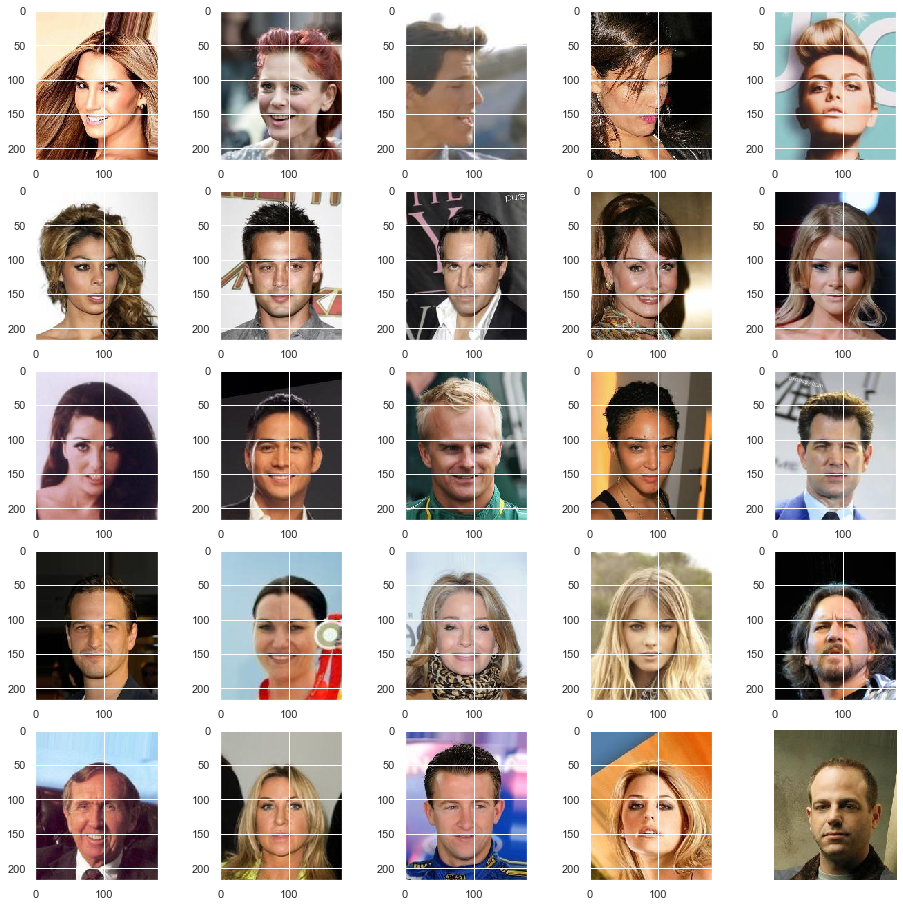

In [103]:
# extract the face from a lodaded image and resize
def extract_face(model:MTCNN, image:np.ndarray, required_size=(80,80)):
    faces = model.detect_faces(image)

    # skip faces where we wud not detect a face
    if len(faces) == 0:
        return None

    # extract details of the face
    box = faces[0]['box']
    x1, y1, width, height = box


    # retrieve face pixels
    face_pixels = image[abs(y1): abs(y1) + height,
                        abs(x1) : abs(x1) + width]

    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [104]:
# load images and extract faces for all images in a dir
def load_faces(dir, n_faces) -> np.ndarray:

    # prepare MTCNN model
    model = MTCNN()
    faces = []

    for filename in os.listdir(dir):
        pixels = load_image(img_dir + r"/" + filename)

        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue

        # store
        faces.append(face)
        #print(f"LenFaces: {len(faces)} , FaceShape: {face.shape}")

        if len(faces) >= n_faces:
            break
    return np.asarray(faces)

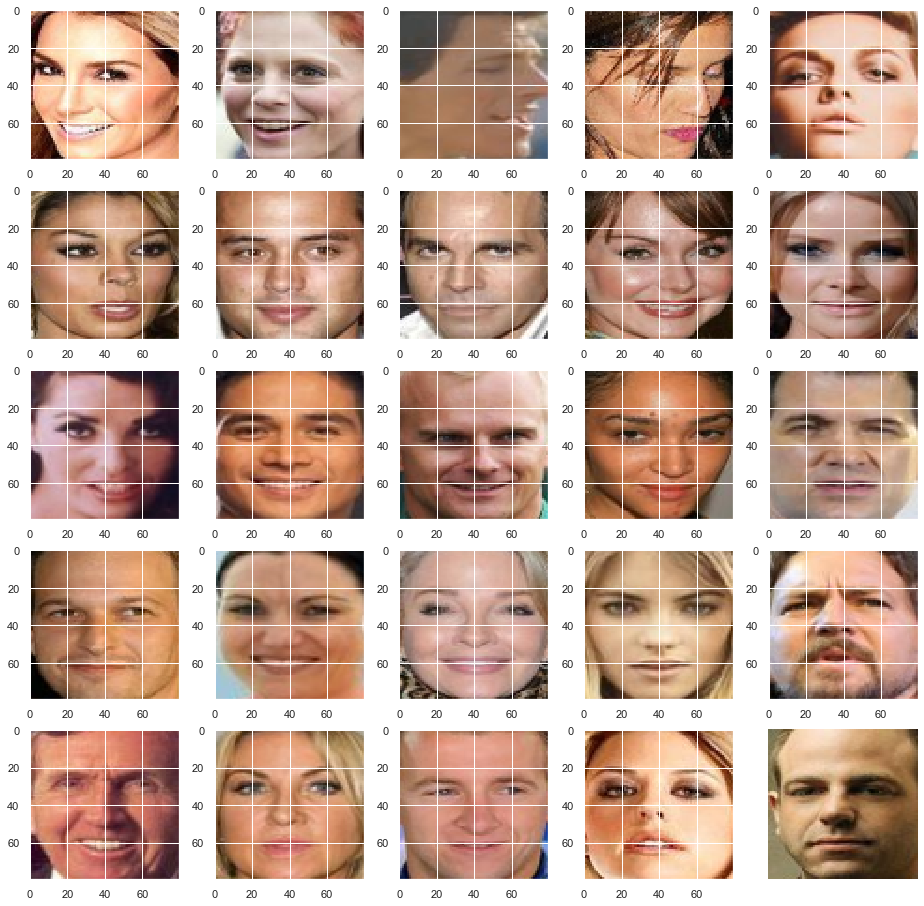

In [105]:
faces = load_faces(img_dir, 25)
plot_faces(faces, 5)

In [ ]:
# create a 50,000 size dataset for trainign  GAN
all_faces = load_faces(img_dir, n_faces=50_000)

In [63]:
savez_compressed('img_align_celeba.npz', all_faces)

In [106]:
# load the prepared dataset
data = np.load('img_align_celeba.npz')

In [107]:
# define the standalone discriminator
def define_discriminator(in_shape=(80, 80, 3)):

    model = Sequential()

    # CONV
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     padding='same',
                     input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # CONV
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     padding='same',
                     strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # CONV
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     padding='same',
                     strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # CONV
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     padding='same',
                     strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    # CONV
    model.add(Conv2D(filters=128,
                     kernel_size=(5,5),
                     padding='same',
                     strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [108]:
def define_generator(latent_dim):
    model = Sequential()

    # foundation for 5x5 feature maps
    n_nodes = 128*5*5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))

    #10*10
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

        #20*20
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

        #40*40
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

        #10*10
    model.add(Conv2DTranspose(filters=128,
                              kernel_size=(4,4),
                              strides=(2,2),
                              padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

In [109]:
# define the combined GAN model
def define_gan(g_model:Model, d_model:Model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [110]:
# load and prepare trainign images
def load_real_samples():
    data = np.load('img_align_celeba.npz')
    x = data['arr_0']
    x = x.astype('float32')
    x = (x-127.5) / 127.5
    return x

In [111]:
# select random real samples
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    y = np.ones((n_samples, 1))
    return x, y

In [112]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [113]:
def generate_fake_samples(g_model:Model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return x, y

In [114]:
def save_plot(examples, epoch, n=10):
    # plot images
    f, ax = plt.subplots(n, n, figsize=(30,30)) #type: Figure, axes
    plt.axis('off')
    plt.grid('off')

    examples_iter = iter(examples)
    for row in range(n):
        for col in range(n):
            ax[row][col].imshow(next(examples_iter))

    # save plot to file
    filename = f"generated_plot_epoch{epoch+1}.png"
    plt.savefig(filename)
    plt.close()

def summarise_performance(epoch,
                          g_model:Model,
                          d_model:Model,
                          dataset:np.ndarray,
                          latent_dim,
                          n_samples=100):
    # get real samples
    xreal, yreal = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real samples
    loss_real, acc_real = d_model.evaluate(xreal, yreal, verbose=0)

    # prepare fake samples
    xfake, yfake = generate_fake_samples(g_model, latent_dim, n_samples)

    # eval discrimiantor on fake samples
    loss_fake, acc_fake = d_model.evaluate(xfake, yfake, verbose=0)

    # summarise discrimiantor performance
    print(f"Epoch={epoch+1} Discriminator Accuracy  "
          f"Real={acc_real*100} and "
          f"Fake={acc_fake*100}")

    # save the plot
    save_plot(xfake, epoch)

    # save the generaor model to file
    g_model.save(f"generator_model_epoch{epoch+1}.hdf5")

In [115]:
# train the generator and the discriminator
def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim: int,
          n_epochs=100,
          n_batch=128):

    # evaluate batch per epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)

    # calculate half-batch
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):

        # enumerate bacthes over the trainign set
        for j in range(bat_per_epo):

            # get randomly selected real samples
            xreal, yreal = generate_real_samples(dataset, half_batch)

            # get fake examples
            xfake, yfake = generate_fake_samples(g_model, latent_dim, half_batch)

            # update the discrinator on real images
            d_loss1, d_acc1 = d_model.train_on_batch(xreal, yreal)

            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(xfake, yfake)

            # prepare points in the latent space as inputs for the generator
            xgan = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            ygan = np.ones((n_batch, 1))

            # update the generator via the discriminators error
            g_loss = gan_model.train_on_batch(xgan, ygan)

            # summarise the loss in this batch
            print(f"Train Epoch: {i+1}, {j+1}/{bat_per_epo} d1={d_loss1}, "
                  f"d2={d_loss2} g={g_loss}")

        if i % 10 == 0:
            summarise_performance(i, g_model, d_model, dataset, latent_dim)